# Exercise 5

Work on this before the next lecture on 8 May. We will talk about questions, comments, and solutions during the exercise after the third lecture.

Please do form study groups! When you do, make sure you can explain everything in your own words, do not simply copy&paste from others.

The solutions to a lot of these problems can probably be found with Google. Please don't. You will not learn a lot by copy&pasting from the internet.

If you want to get credit/examination on this course please upload your work to **your GitHub repository** for this course **before** the next lecture starts and post a link to your repository [in this thread](). If you worked on things together with others please add their names to the notebook so we can see who formed groups.

---

These are some useful default imports for plotting and [`numpy`](http://www.numpy.org/)

In [69]:
%config InlineBackend.figure_format='retina'
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams["font.size"] = 14
from sklearn.utils import check_random_state

## Question 1

You can use PCA as a form of noise filtering. The idea why this might work goes like this: overall the PCA components representing the noise will explain less of the variance in the dataset than the components related to the actual data. So if you keep only the high variance components you can remove (some) of the noise.

* plot some of the digits before and after the noise has been added
* fit a `PCA` transformer to the digit dataset
* experiment with the number of components you need to get a good reconstruction of the digits that supresses the noise.
* (bonus) is there a quantitative way to pick the best number of components?

(Note: You can use this for high dimensional tabular data as well. Instead of training your classifier on all the features you can first transform your data and only use the first "few" components, thereby removing the noise.)

In [70]:
from sklearn.datasets import load_digits
digits = load_digits()

# fluctuate each pixel's intensity by drawing from a gaussian
# with mean equal to the pixels value and std=4
np.random.seed(42)
noisy = np.random.normal(digits.data, 4)

### Plot some digits before and after the gaussian noise has been added.

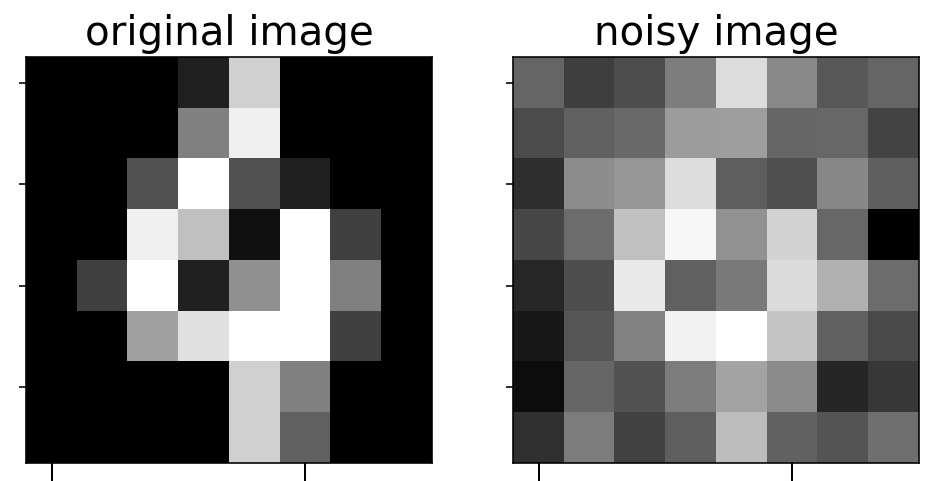

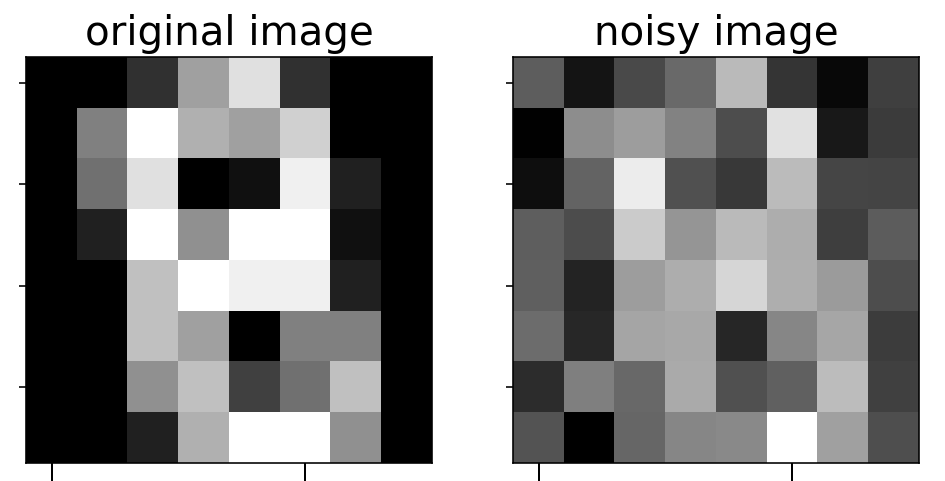

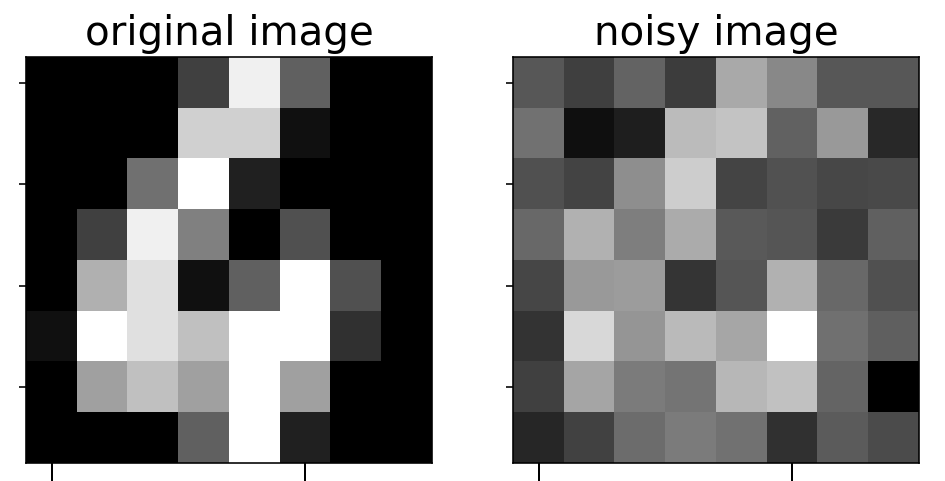

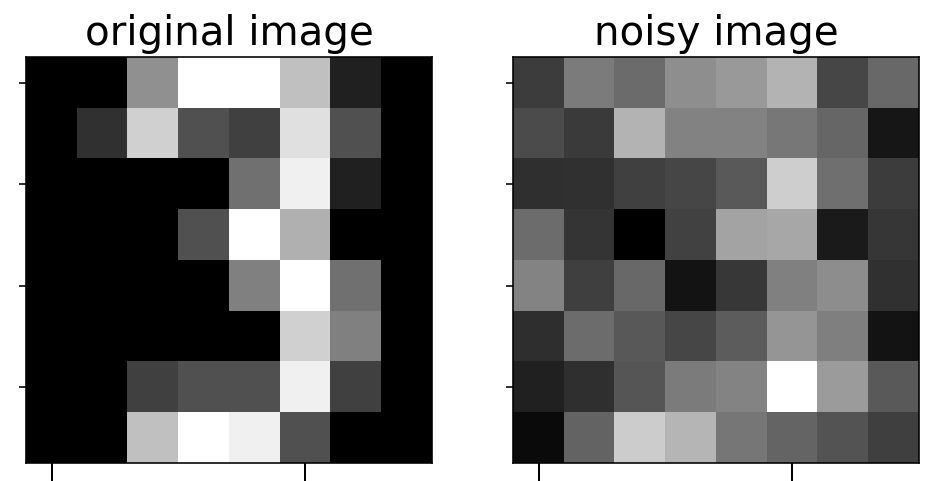

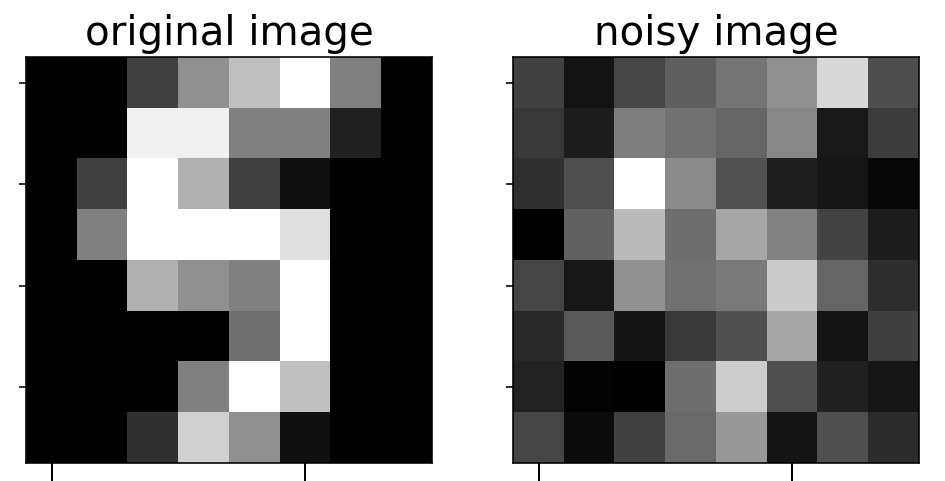

In [71]:
for i in [100,500,900,1300,1700]:
    fig, axs = plt.subplots(1, 2, figsize=(2*4, 4))
    # original image
    axs[0].imshow(digits.images[i], cmap='gray')
    axs[0].set_yticklabels([])
    axs[0].set_xticklabels([])
    axs[0].set_title("original image")
    # noisy image
    axs[1].imshow(noisy[i].reshape(8,8), cmap='gray')
    axs[1].set_yticklabels([])
    axs[1].set_xticklabels([])
    axs[1].set_title("noisy image")

Note that the pixel intensity can be negative in the case of the noisy image, so the colorscale are different between the original image and noisy one.

### Experiment with the number of components

In [76]:
from sklearn.decomposition import PCA
from ipywidgets import interact

# Borrowed from the lecture
def show_noisy_digit(n_components=6):
    fig, axs = plt.subplots(5, 4, figsize=(4*4, 5*4))

    for n,num in enumerate([100,500,900,1300,1700]):
        digit_img = digits.images[num]
        ax = axs[n,0]
        ax.set_title('original image')
        ax.imshow(digit_img, cmap='gray')
        ax.set_yticklabels([])
        ax.set_xticklabels([])

        # noisy image
        noisy_digit = noisy[num]
        
        ax = axs[n,1]
        ax.imshow(noisy_digit.reshape(8,8), cmap='gray')
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        ax.set_title("noisy image")
        
        #
        pca_noisy = PCA(n_components)
        
        pca_noisy.fit(noisy_digit.reshape(1,-1))

        # components
        ax = axs[n,2]
        if n_components == 1:
            template = pca.mean_.reshape(8,8)
        else:
            template = pca.components_[n_components-1].reshape(8,8)
        template = pca.components_[n_components-1].reshape(8,8)
        ax.imshow(template, cmap='gray')
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        ax.set_title("last component")
        
        # reconstruction
        ax = axs[n,3]
        ax.imshow(pca_noisy.inverse_transform(pca_noisy.transform(noisy_digit.reshape(1, -1))).reshape(8,8), 
                  cmap='gray')
        ax.set_title('mean + first %i components' % (n_components))
        ax.set_yticklabels([])
        ax.set_xticklabels([])
    plt.show()
    
interact(show_noisy_digit, n_components=(1,30));

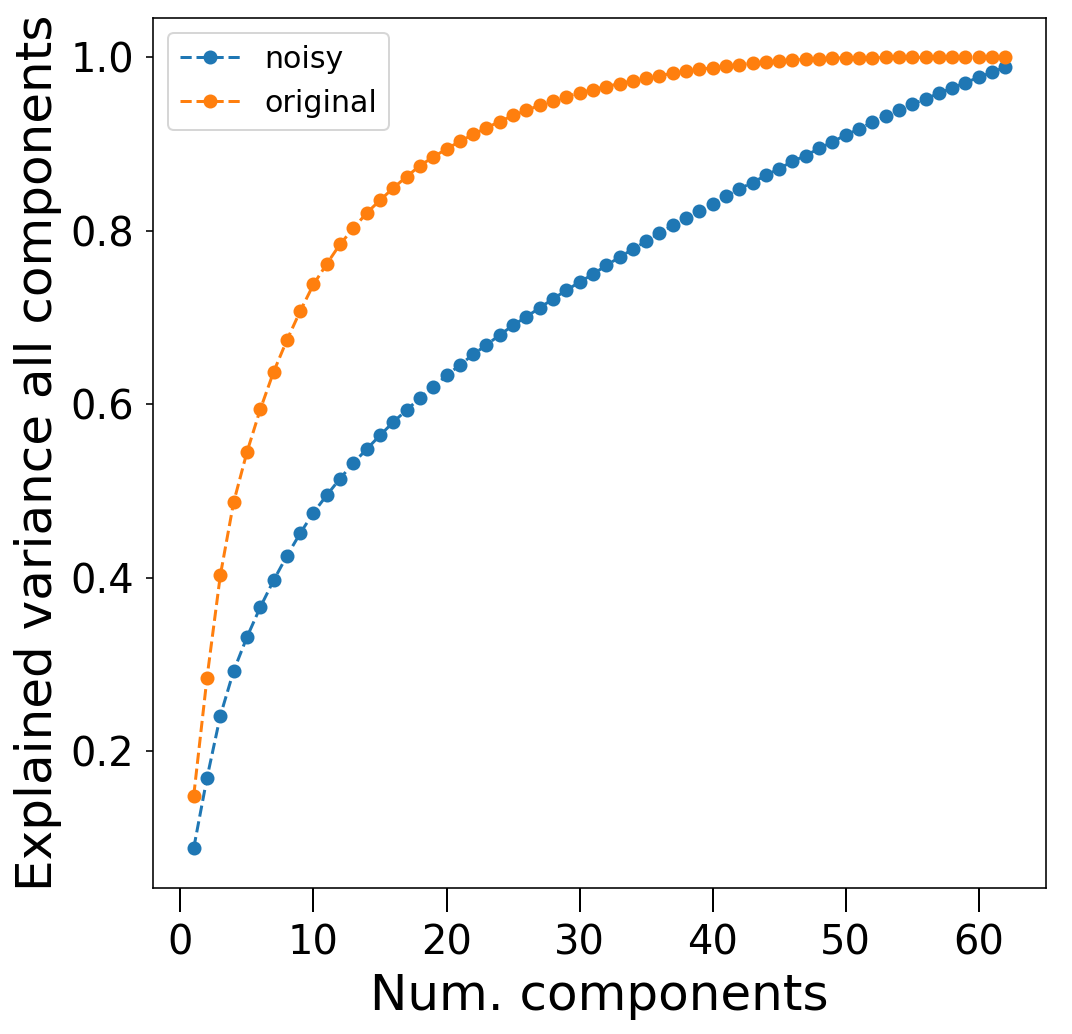

In [83]:
range_n_components = range(1,63)

list_sum_var_ratio_noisy = []
list_sum_var_ratio_original = []


for n_components in range_n_components:
    pca_noisy = PCA(n_components)
    pca_noisy.fit(noisy)
    list_sum_var_ratio_noisy.append(np.sum(pca_noisy.explained_variance_ratio_))
    pca_original = PCA(n_components)
    pca_original.fit(digits.data)
    list_sum_var_ratio_original.append(np.sum(pca_original.explained_variance_ratio_))

    
plt.plot(range_n_components, list_sum_var_ratio_noisy, 'o--', label='noisy')
plt.plot(range_n_components, list_sum_var_ratio_original, 'o--', label='original')
plt.ylabel("Explained variance all components")
plt.xlabel("Num. components")
plt.legend(loc='best')

As we increase the number of components the ratio of the total variance explained by all of them together monotonically increase. But we arrive at a certain point (in this case around n_components = 10) where further increasing the number of components does not increment the explained variance at the same pace as before. Indeed, what happens is that the sum of the explained variance ratio changes the slope quite quickly. This is true for both datasets, even if such behavior is more visible for the original dataset.

### (bonus) is there a quantitative way to pick the best number of components?



When sorted in order of explained variance, I expect that the PCA components which are the most 'predictive' are the ones that capture common pixel features from the images (which correspond to the shape of the digits), while the components that capture the noise should not be among the most relevant since noise, by definition, does not contribute to construct regular patterns on the images that are usually capture by PCA most relevant components.

I guess that the components that capture noise should have similar characteristic, e.g. their average should be similar, while significant components should have something in common between them since they all encode some kind of pattern.

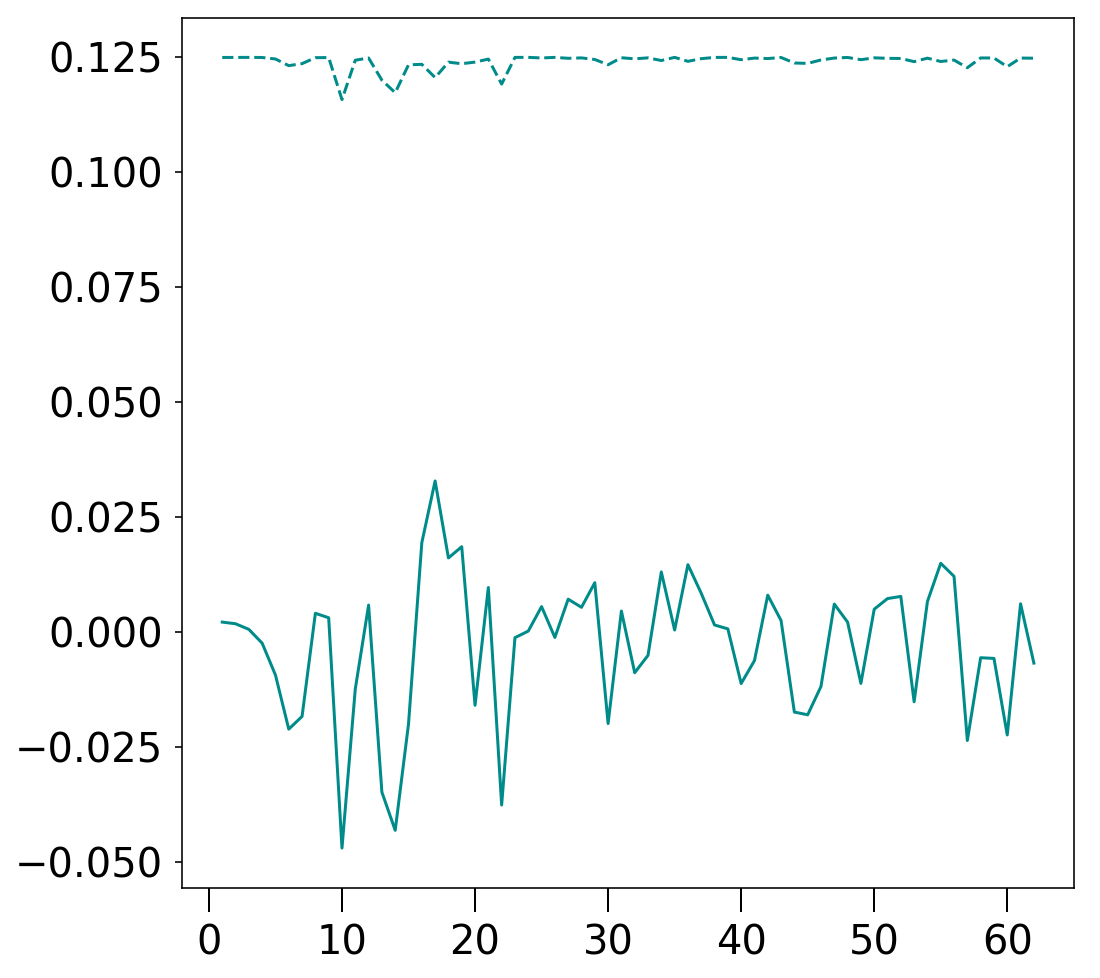

In [90]:
pca_noisy = PCA(62)
pca_noisy.fit(noisy)

avg_comp = []
std_comp = []

for c in range(pca_noisy.n_components_):
    comp = pca_noisy.components_[c]
    avg_comp.append( np.mean(comp) )
    std_comp.append( np.std(comp) )
    
avg_comp = np.array(avg_comp)
std_comp = np.array(std_comp)
    
plt.plot(range(1,pca_noisy.n_components_+1), avg_comp, ls="-", c='darkcyan')
plt.plot(range(1,pca_noisy.n_components_+1), std_comp, ls="--", c='darkcyan')
    

I think what I said before is wrong, in the sense that a criterion to establish the optimal number of components must be based on something that is different from maximizing the explained variance (of course) but should be more oriented toward finding characteristic patterns of the important components against the random patterns of the ones that capture the noise. Maybe some correlation between them may help in this task?

---

## Question 2

Apply PCA to a dataset that contains two gaussian blobs. Imagine this is a toy version of a real problem where you are trying to separate the dark from the light points. Before using the `PCA` transformer make a prediction for the two principle components from your intuition.

* draw the principle components PCA finds
* reduce the dimensionality of the data to one dimension using the `transform` method of the `PCA` transformer
* plot your transformed dataset, can you separate the two classes using only the first principle component?
* A technique related to PCA that makes use of the class labels is called linear discriminant analysis (LDA). How does LDA perform on this problem?
* Can you explain why PCA fails?

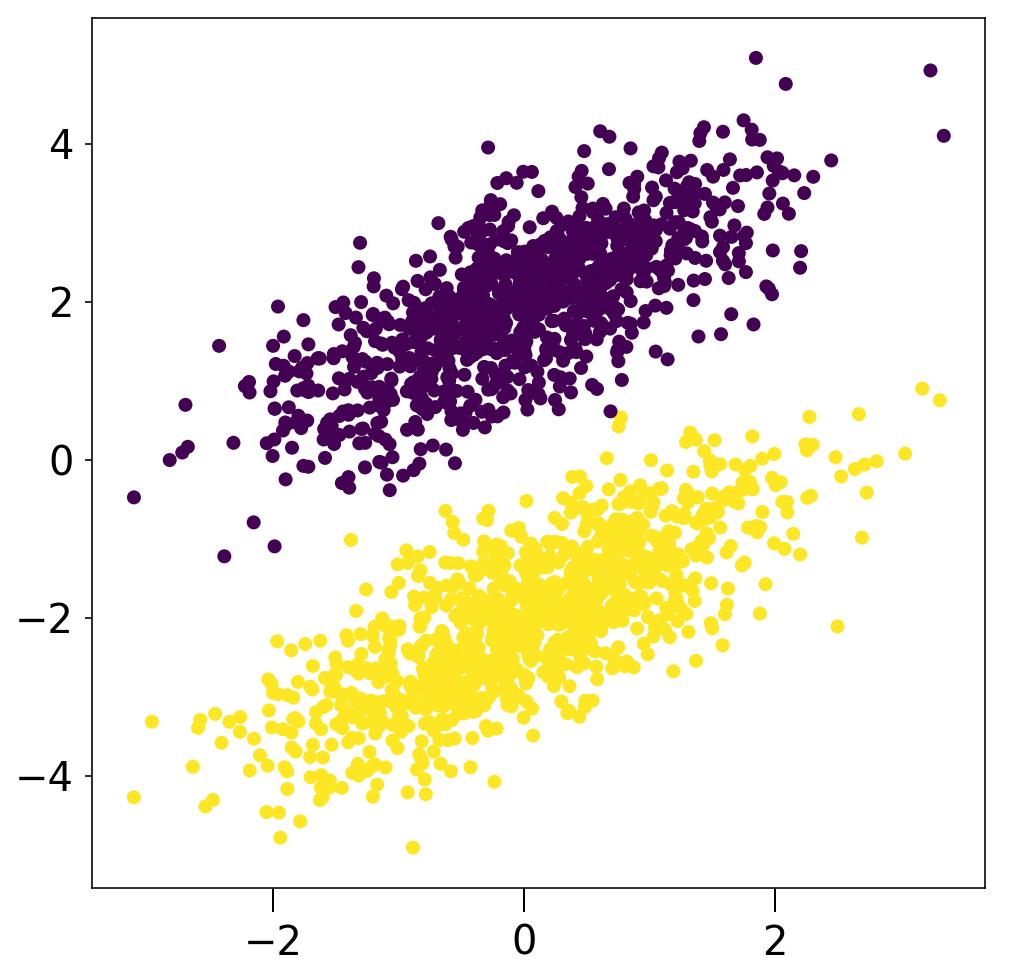

In [91]:
N = 1000
m1 = (1,1)
m2 = (1,4)
C = ((1,0.75), (0.75,1))
g1 = np.random.multivariate_normal((0, -2), C, N)
g2 = np.random.multivariate_normal((0, +2), C, N)

X = np.vstack((g1, g2))
y = np.hstack((np.ones(N), np.zeros(N)))

plt.scatter(X[:,0], X[:,1], c=y);

### Two principal components by reasoning

I expect that the first principal component is the one that describes the spread of the points along the diagonal line, i.e. the one that goes roughly from (-2,-4) to (2,0) for yellow points. The second is the one orthogonal to this direction that describe a spread that is almost vertical.

[-0.00282675 -0.01757699] [ 0.71794098  4.40219939]
[-0.00282675 -0.01757699] [ 1.84154204 -0.31835273]


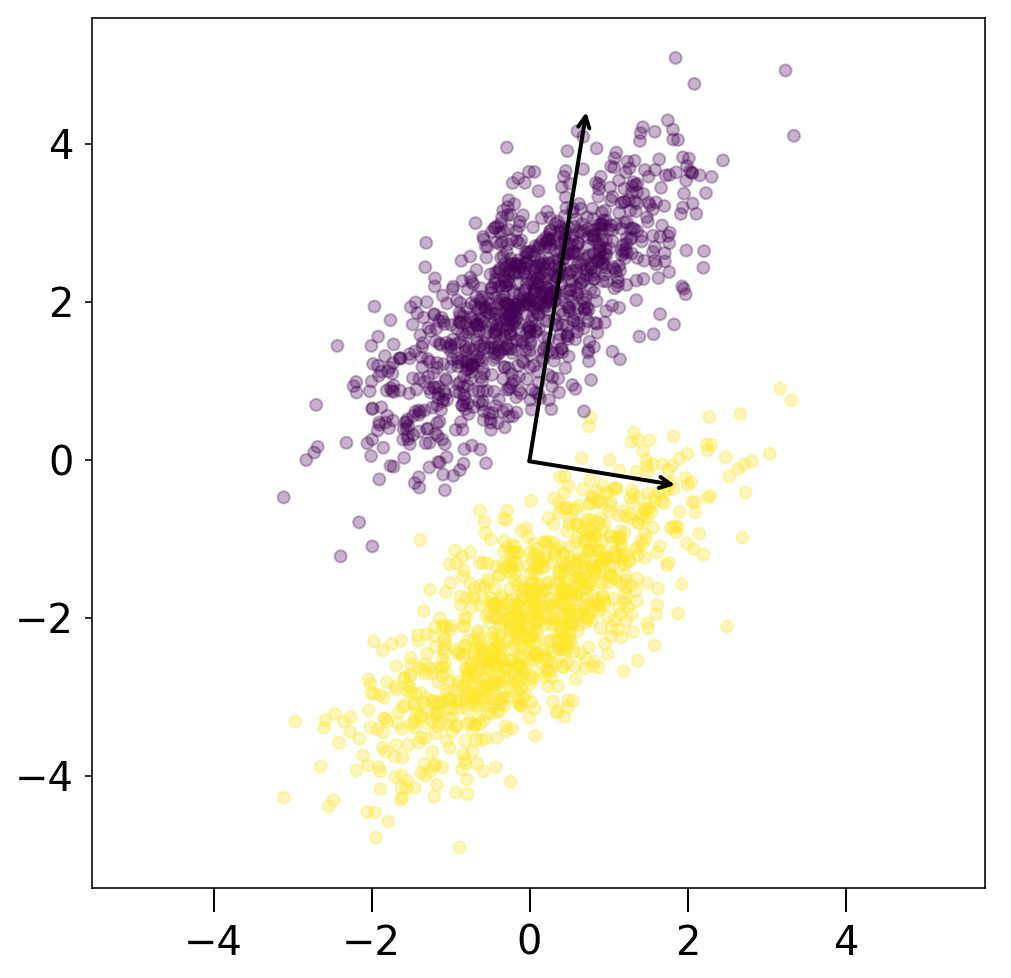

In [103]:
# borrowed from the lecture for the drawing

def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->', linewidth=2, shrinkA=0, shrinkB=0)
    ax.annotate('', v1, v0, arrowprops=arrowprops)

pca = PCA(2)
pca.fit(X)

plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.3)
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 2 * np.sqrt(length)
    draw_vector(pca.mean_, pca.mean_ + v)
plt.axis('equal');

# X_new = pca.inverse_transform(X_pca)
# plt.scatter(X[:, 0], X[:, 1], alpha=0.4, label='original')
# plt.scatter(X_new[:, 0], X_new[:, 1], alpha=0.8, label='re-projected')
# plt.xlabel("X")
# plt.ylabel("Y")
# plt.legend(loc='best')
# plt.axis('equal');

### reduce the dimensionality of the data to one dimension using the `transform` method of the `PCA` transformer and plot your transformed dataset, can you separate the two classes using only the first principle component?

<Container object of 10 artists>

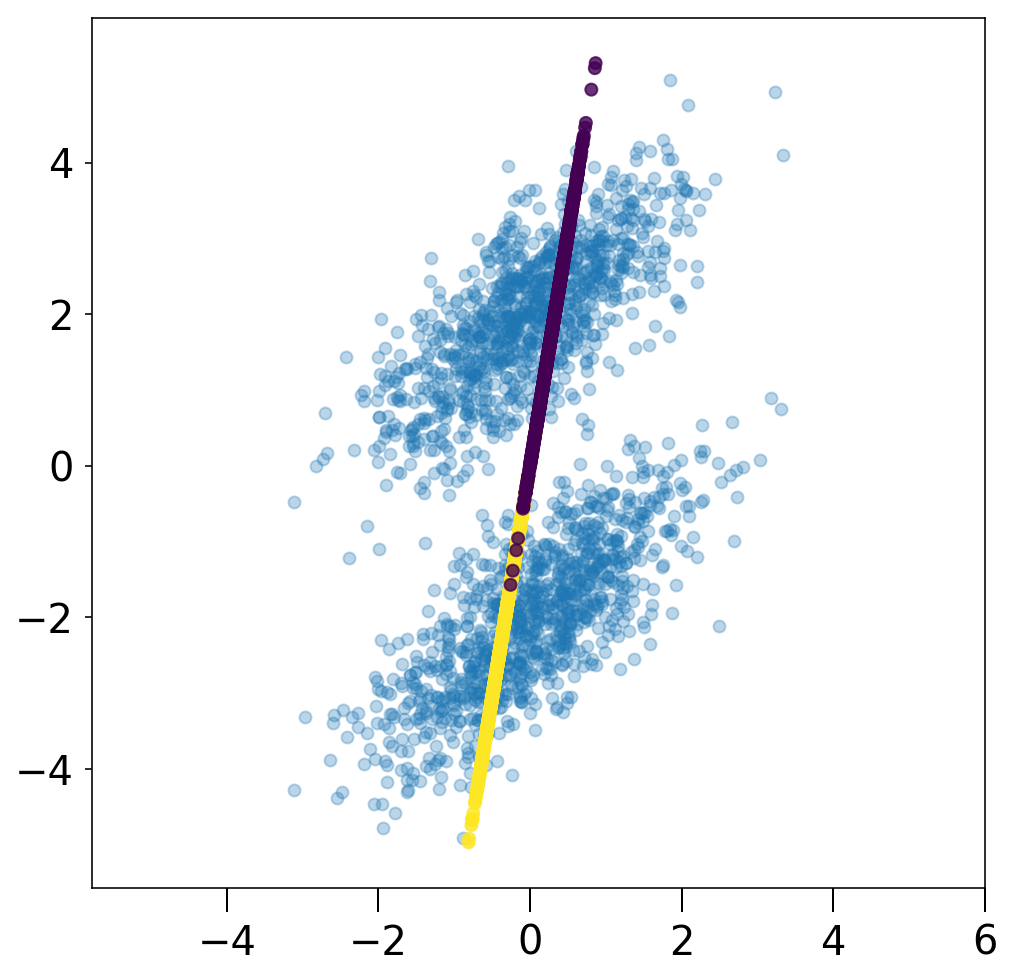

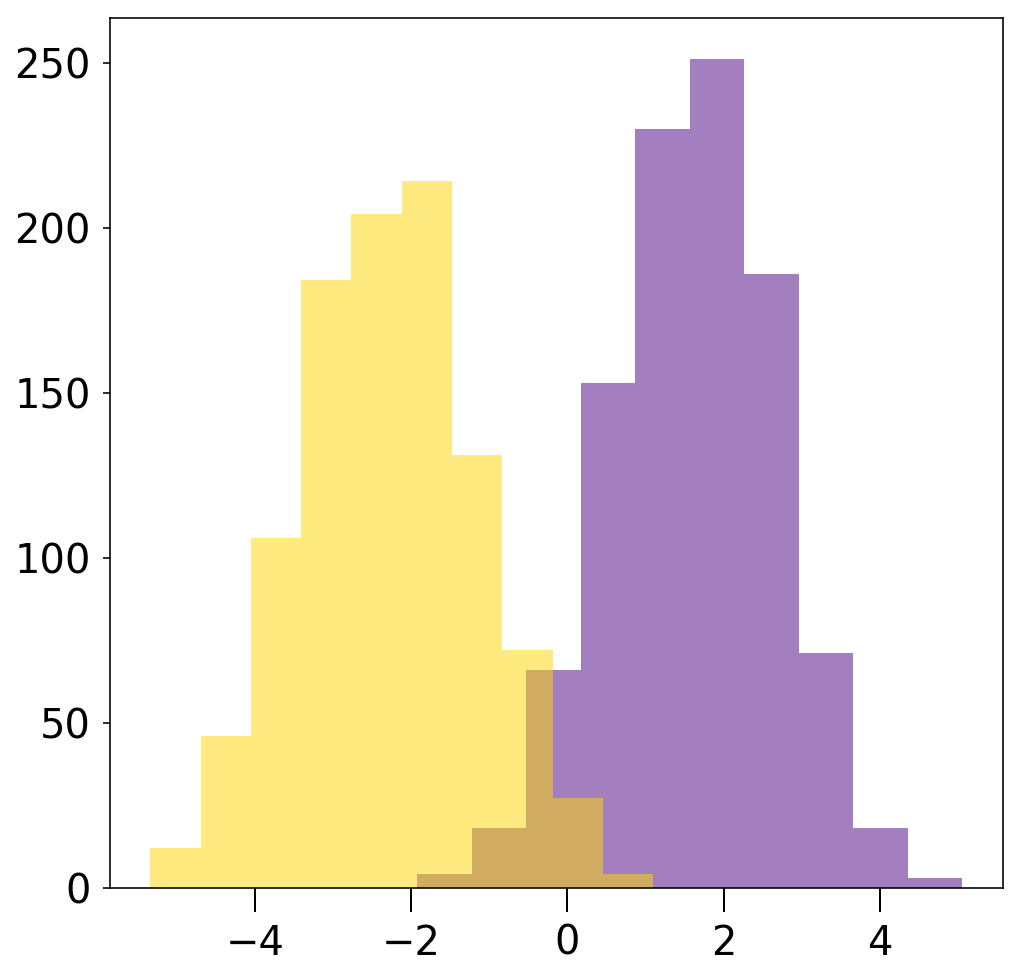

In [125]:
pca = PCA(n_components=1)
pca.fit(X)
# transforming data using the 1st principal component as reference axis.
X_pca = pca.transform(X)

# project back onto the 2D space the transformed data.
X_new = pca.inverse_transform(X_pca)
plt.scatter(X[:, 0], X[:, 1], alpha=0.3)
plt.scatter(X_new[:, 0], X_new[:, 1], alpha=0.8, c=y)
plt.axis('equal');

comp1_1 = X_pca[y == 0]
comp1_2 = X_pca[y == 1]

vs_1, bs_1 = np.histogram(comp1_1)
vs_2, bs_2 = np.histogram(comp1_2)

plt.figure()

plt.bar(bs_1[:-1], vs_1, width=bs_1[1:]-bs_1[:-1], alpha = 0.5, color='indigo')
plt.bar(bs_2[:-1], vs_2, width=bs_2[1:]-bs_2[:-1], alpha = 0.5, color='gold')

Yes, the separation is not perfect and points closer to the yellow ones may be misclassified as violet using the first PCA component (and viceversa), but in principle values positive values for first component are violet while neagative values correspond to yellow points, as can be appreciated from the histogram of X_pca.

### Using Linear Discriminant Analysis (LDA) with labels. How does LDA perform on this problem?

In [128]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis()

lda.fit(X, y)
y_pred = lda.predict(X)


print("Variance ratio explained by LDA: ", lda.explained_variance_ratio_)
print("Variance ratio explained by PCA: ", pca.explained_variance_ratio_)

Variance ratio explained by LDA:  [ 1.]
Variance ratio explained by PCA:  [ 0.85168824]


It seems that LDA with 1 component perfectly separate the points

In [142]:
print(y.shape[0])
print(np.where(y_pred == y)[0].shape[0])

2000
1999


All the points are correctly predicted but one, marked with a red cross, that should be yellow instead of violet.

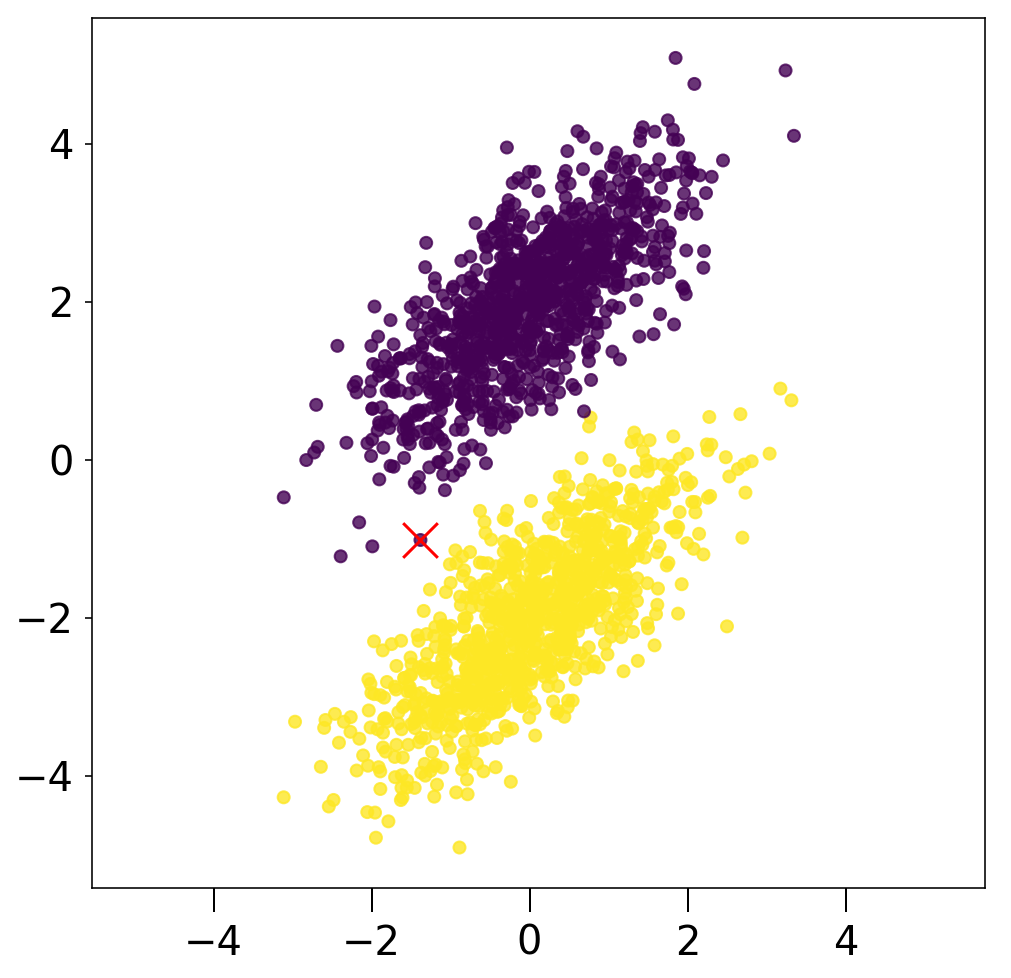

In [148]:
plt.figure()
plt.scatter(X[:, 0], X[:,1], alpha=0.8, c=y_pred)
indx_misclassified = np.where(y_pred != y)
plt.scatter(X[indx_misclassified, 0], X[indx_misclassified,1], marker="x", s=300, c='r')
plt.axis('equal');

PCA fails since the greatest variance in the dataset is almost parallel to the y axis but is not exactly perpendicular to the line that separate yellow and violet points. Hence, it cannot be used to efficiently sepatate points based on the value of such X_pca coordinate.

## Question 3

Create a simple Auto Encoder using `keras`. By forcing the input through a bottleneck we can hope that the auto encoder focusses on interesting structure in the data and ignores noise. Maybe auto encoders can be used to perform denoising.

* create your own auto encoder setup or start from the one shown in the lecture. You might have to construct a auto encoder that has more layers or uses more powerful transformations like `Conv2D`, `MaxPooling2D` and `Upsampling2D`.
* make sure to load the MNIST dataset from `keras` and not the digits dataset from scikit-learn. Create a noisy version of your digits by drawing pixel values from a gaussian with mean equal to each pixel's intensity and a small standard deviation (tip: start with little/no noise to debug your auto encoder and then slowly increase the noise)
* how do you need to modify the learning setup compared to the lecture where we use `X_train` both as input and as output?

(Bonus: can you learn an "auto encoder" that rotates clean digits by 90degrees? This shuold start you off thinking about using neural networks as general purpose "transformers".)

### My neural network

In [153]:
from keras.layers import Input, Dense, Conv2D, Activation, MaxPooling2D, Dropout
from keras.models import Model, Sequential

# go from 784 dimensions to 32, a reduction of factor 24
encoding_dim = 32

model = Sequential()

model.add( Conv2D(4, (3, 3), input_shape=(28, 28, 1)) )
model.add( Activation('relu') )
model.add( MaxPooling2D(pool_size=(2, 2)) )

model.add( Dense(encoding_dim, activation='relu') )
model.add( Dense(784, activation='relu'))

# model.add(Conv2D(32, (3, 3)))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Conv2D(64, (3, 3)))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))


model.compile(optimizer='adam', loss='mean_squared_error')

### load the MNIST dataset. Create a noisy version of your digits by drawing pixel values from a gaussian with mean equal to each pixel's intensity and a small standard deviation (tip: start with little/no noise to debug your auto encoder and then slowly increase the noise)

In [154]:
from keras.datasets import mnist
from sklearn.model_selection import train_test_split

# note: the MNIST dataset has more features and more samples than the digits
# dataset in scikit-learn
# Only load the training images, we don't need more and we do not care for the labels
(x_train, y_train), (_, _) = mnist.load_data()

print(x_train.shape)

x_train = x_train.reshape(-1, 28*28)

X = x_train / 255

X_train, X_test, y_train, y_test = train_test_split(X, y_train,
                                                    train_size=0.8, random_state=1)

(60000, 28, 28)


In [ ]:
np.random.seed(42)

# Create a function to add a tunable amount of noise to the train data specified by the standard deviation.

def noisify_data(X_train, std_val):
    noisy_digits = np.random.normal(X_train, std_val)
    return noisy_digits

In [ ]:
nn = model.fit(X_train, X_train,
                        epochs=50,
                        batch_size=256,
                        shuffle=True,
                        verbose=False,
                        validation_data=(X_test, X_test))

---

## (Bonus) Question 4

Using your auto encoder architecture from the previous question, a clean MNIST dataset, and the ideas from the "visual search" notebook can you create a search engine that can find images similar to the query image?

In [ ]:
# your answer here